### Plot IDM results using the DataFrame stored in IDMResults.pcl 

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import griddata

pd.options.mode.chained_assignment = None #Disable copy warnings
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
def getSmoothCurve(x,y,z,stepX=20.,stepY=0.5,doLog=True,doMax=True,cval=1.):

    if doLog:
        yv = np.log10(y[y > 0.]).tolist()
        xv = x[y > 0.].tolist()
        zv = z[y > 0.].tolist()
    else:
        yv = y.tolist()
        xv = x.tolist()    
        zv = z.tolist()
    
    points = list(zip(xv,yv))
    xbins = np.arange(min(xv),max(xv),stepX)
    ybins = np.arange(min(yv),max(yv),stepY)
    zvals = np.array([[0.]*len(ybins)]*len(xbins))
    for ipt,pt in enumerate(points):
        if not (xbins.min() < pt[0] < xbins.max()):
            continue
        if not (ybins.min() < pt[1] < ybins.max()):
            continue
        ix = np.searchsorted(xbins,pt[0])-1
        iy = np.searchsorted(ybins,pt[1])
        if doMax:
            zvals[ix,iy] = max(zvals[ix,iy],zv[ipt])
        else:
            if zvals[ix,iy] == 0.:
                zvals[ix,iy] = zv[ipt]
            else:
                zvals[ix,iy] += zv[ipt]
                zvals[ix,iy] = zvals[ix,iy]/2.            

        
    xpoints = []
    ypoints = []
    zpoints = []
    for ix,xval in enumerate(xbins):
        for iy,yval in enumerate(ybins):
            xpoints.append(xval)
            ypoints.append(yval)
            zpoints.append(zvals[ix,iy])
    cs = plt.tricontour(xpoints,ypoints,zpoints,levels=[cval],linewidths=0)
    curve = None
    for c in cs.collections[0].get_paths():
        if curve is None:
            curve = c.vertices
        elif len(c.vertices) > len(curve):
            curve = c.vertices
    plt.cla()
    if doLog:
        curve[:,1] = np.power(10,curve[:,1])
    return curve

In [3]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('IDMResults.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=True)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.
#Replace zero widths by small value:
# dataDF = dataDF[dataDF['width.37'] > 0.]
dataDF['width.37'] = dataDF['width.37'].map(lambda x: x if x > 0. else 1e-50)
dataDF['ctau.37'] = 1.967e-16/dataDF['width.37']
#Restrict ctau range:
dataDF = dataDF[(dataDF['ctau.37'] > 0.01) & (dataDF['ctau.37'] < 1e5)]

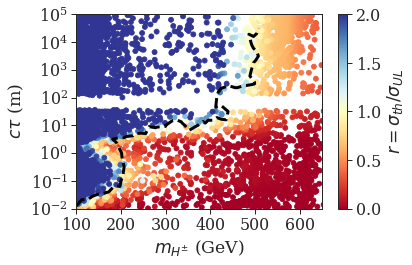

In [5]:
mHc = dataDF['mass.37']
ctau = dataDF['ctau.37']
r = dataDF['ExptRes.result0.r']
x,y,z = mHc,ctau,r
# # Plot scatter plot (for double checking the results)
# cs = plt.tricontour(x,np.log10(y),z,levels=[1.],linewidths=0)
plt.figure()
curve = getSmoothCurve(x,y,z,stepX=18.,stepY=0.5,doLog=True,doMax=True)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=25, cmap=cm)
plt.plot(curve[:,0],curve[:,1],color='black',linewidth=3,linestyle='--')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{H^{\pm}}$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(y.min(),y.max())
plt.yticks(np.power(10.,np.arange(-2., 6., 1.)))
plt.xlim(100,650)
plt.xticks(np.arange(100.,700.,100.))
plt.tight_layout()
plt.savefig('IDM_points_r.png',dpi=500)
plt.show()

0.012185636516554053
508.44213594484404


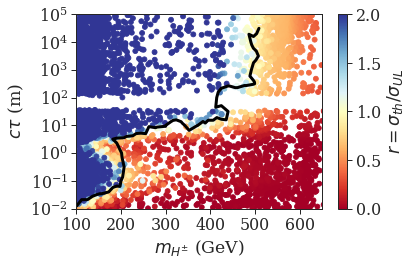

In [6]:
mHc = dataDF['mass.37']
ctau = dataDF['ctau.37']
r = dataDF['ExptRes.result0.r']
x,y,z = mHc,ctau,r
# # Plot scatter plot (for double checking the results)
# cs = plt.tricontour(x,np.log10(y),z,levels=[1.],linewidths=0)
plt.figure()
curve = getSmoothCurve(x,y,z,stepX=18.,stepY=0.5,doLog=True,doMax=True)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=25, cmap=cm)
plt.plot(curve[:,0],curve[:,1],color='black',linewidth=3,linestyle='-')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{H^{\pm}}$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(y.min(),y.max())
plt.yticks(np.power(10.,np.arange(-2., 6., 1.)))
plt.xlim(100,650)
plt.xticks(np.arange(100.,700.,100.))
plt.tight_layout()
plt.savefig('IDM_points_r_solid.png',dpi=500)
print(curve[:,1].min())
print(curve[:,0].max())
plt.show()

0.462696109053792
503.6568207988008


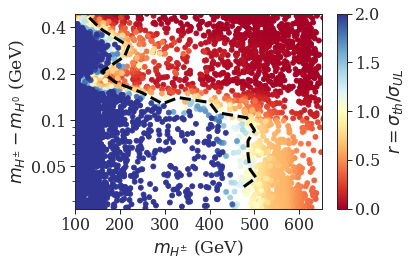

In [7]:
deltaM = (dataDF['mass.37']-dataDF['mass.35'])
mHc = dataDF['mass.37']
r = dataDF['ExptRes.result0.r']
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mHc,deltaM,r
plt.figure()
curveDM = getSmoothCurve(x,y,z,stepX=30.,stepY=0.04,doLog=True,doMax=True)
#Clean curve:
imax = np.where(curveDM[:,0] == curveDM[:,0].max())[0][0]
curveDM = curveDM[imax-5:]
curveDM = [curveDM[0].tolist()] + curveDM[::5].tolist() + [curveDM[-1].tolist()]
curveDM = np.array(curveDM)

cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=25, cmap=cm)
plt.plot(curveDM[:,0],curveDM[:,1],c='black',linewidth=3,linestyle='--')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{H^{\pm}}$ (GeV)') 
plt.ylabel(r'$m_{H^{\pm}} - m_{H^{0}}$ (GeV)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(y.min(),y.max())
plt.yticks([0.05,0.1,0.2,0.4],['0.05','0.1','0.2','0.4'])
plt.xlim(100,650)
plt.xticks(np.arange(100.,700.,100.))
print(curveDM[:,1].max())
print(curveDM[:,0].max())
plt.tight_layout()
plt.savefig('IDM_points_deltaM_r.png',dpi=500)
plt.show()

0.462696109053792
503.6568207988008


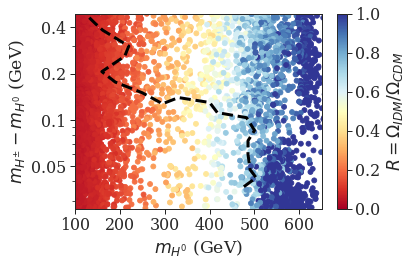

In [8]:
relicRatio = dataDF['rat']
z = relicRatio
plt.figure()
cp = plt.scatter(x,y, c=z, vmin=0., vmax=1., s=25, cmap=cm)
plt.plot(curveDM[:,0],curveDM[:,1],c='black',linewidth=3,linestyle='--')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{H^0}$ (GeV)')    
plt.ylabel(r'$m_{H^{\pm}} - m_{H^{0}}$ (GeV)')
cb.set_label(r'$R= \Omega_{IDM}/\Omega_{CDM}$')
plt.ylim(y.min(),y.max())
plt.yticks([0.05,0.1,0.2,0.4],['0.05','0.1','0.2','0.4'])
plt.xlim(100,650)
plt.xticks(np.arange(100.,700.,100.))
print(curveDM[:,1].max())
print(curveDM[:,0].max())
plt.tight_layout()
plt.savefig('IDM_relicRatio_deltaM.png',dpi=500)
plt.show()

0.462696109053792
503.6568207988008


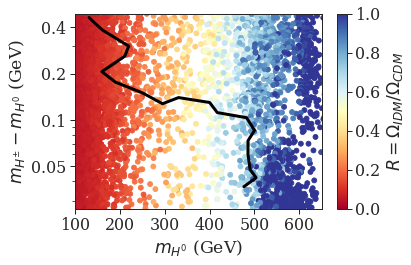

In [9]:
relicRatio = dataDF['rat']
z = relicRatio
plt.figure()
cp = plt.scatter(x,y, c=z, vmin=0., vmax=1., s=25, cmap=cm)
plt.plot(curveDM[:,0],curveDM[:,1],c='black',linewidth=3,linestyle='-')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{H^0}$ (GeV)')    
plt.ylabel(r'$m_{H^{\pm}} - m_{H^{0}}$ (GeV)')
cb.set_label(r'$R= \Omega_{IDM}/\Omega_{CDM}$')
plt.ylim(y.min(),y.max())
plt.yticks([0.05,0.1,0.2,0.4],['0.05','0.1','0.2','0.4'])
plt.xlim(100,650)
plt.xticks(np.arange(100.,700.,100.))
print(curveDM[:,1].max())
print(curveDM[:,0].max())
plt.tight_layout()
plt.savefig('IDM_relicRatio_deltaM_solid.png',dpi=500)
plt.show()